In this exercise, we're working for a company that creates data science content. Our task is to figure out the best content to write about. We'll be scouring the internet to find the answer to the question "What is it that people want to learn about in data science?"

Stack Overflow is a question and answer website 

Stack Exchange employs a reputation award system for its questions and answers. Each post — each question/answer — is a post that is subject to upvotes and downvotes. This ensures that good posts are easily identifiable.

We'll be focusing on the data science & statistics regions of the site:

- __[Data Science](https://datascience.stackexchange.com/)__
- __[Statistics](https://stats.stackexchange.com/)__
- __[AI](https://ai.stackexchange.com/)__
- __[Mathematics](https://math.stackexchange.com/)__
- __[Stack Overflow](https://stackoverflow.com/)__
- __[Database Administration](https://dba.stackexchange.com/)__
- __[Unix](https://unix.stackexchange.com/)__
- __[Software Engineering](https://softwareengineering.stackexchange.com/)__
- __[Data Science](https://datascience.stackexchange.com/)__

The following questions should be answered as we familiarize ourselves with the Data Science stackexchange:

- What kind of questions are welcome on this site? **Questions should be: On topic, practical & answerable based on actual problems**
- What, other than questions, does the site's homepage subdivide into? **Tags, users, companies, and unanswered.**
    - Do any of them look useful to our goal? **Tags and Unanswered seem useful. We can sort tags by most popular topics.** 
- What information is available in each post? **Tags, title, when asked, when modified, views, upvotes, author, answers**

The `Posts`, `PostTags`, `TagSynonyms`, and `Tags` tables look most promising for giving us insight into what the most popular data science topics are.

We start off by running a query on __[data.stackexchange.com](https://data.stackexchange.com/datascience/query/edit/1634280)__ query builder to get only the posts from 2019 with `PostTypeId=1` which corresponds to the post type "question". We'll now load this csv into our notebook.

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [34]:
questions = pd.read_csv("2019_questions.csv")
questions.head()

,Id,CreationDate,Score,Tags,ViewCount,AnswerCount,FavoriteCount
0,55523,2019-07-11 18:04:19,1,<machine-learning><discriminant-analysis>,337,1,1.0
1,55525,2019-07-11 18:22:35,0,<lightgbm>,37,1,NaN
2,55526,2019-07-11 18:23:23,1,<machine-learning><scikit-learn><clustering><f...,40,1,1.0
3,55527,2019-07-11 20:28:22,1,<neural-network><keras><batch-normalization><k...,1574,2,NaN
4,55529,2019-07-11 20:29:40,5,<machine-learning><deep-learning><image-recogn...,133,1,1.0


We can see that `FavoriteCount` seems to be missing values. A lot of values, in fact! More than the number of regular valuesall the other rows put together.

In [35]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6756 entries, 0 to 6755
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             6756 non-null   int64  
 1   CreationDate   6756 non-null   object 
 2   Score          6756 non-null   int64  
 3   Tags           6756 non-null   object 
 4   ViewCount      6756 non-null   int64  
 5   AnswerCount    6756 non-null   int64  
 6   FavoriteCount  1769 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 369.6+ KB


Luckily, this seems to be the only feature with null values.

We can also see that `Tags` is an object type consisting of multiple tags as opposed to individual values or lists of values. Our next goal will be to clean this column.

We can accomplish this by removing each opening tag and each backslash, and replacing closing tags by commas. This will leave us with a comma-separated list of tags that is easy to perform operations on.

In [36]:
questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")

/tmp/ipykernel_12749/833902828.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")


In [37]:
questions["Tags"].head()

0            [machine-learning, discriminant-analysis]
1                                           [lightgbm]
2    [machine-learning, scikit-learn, clustering, f...
3    [neural-network, keras, batch-normalization, k...
4    [machine-learning, deep-learning, image-recogn...
Name: Tags, dtype: object

We'll also clean up a few more columns. `FavoriteCount` will only ever be a whole number, so let's make it an `int`. `CreationDate` should be a datetime object for ease of use.

In [38]:
questions["FavoriteCount"] = questions["FavoriteCount"].fillna(0).astype("int")
questions["CreationDate"] = pd.to_datetime(questions["CreationDate"])

In [39]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6756 entries, 0 to 6755
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             6756 non-null   int64         
 1   CreationDate   6756 non-null   datetime64[ns]
 2   Score          6756 non-null   int64         
 3   Tags           6756 non-null   object        
 4   ViewCount      6756 non-null   int64         
 5   AnswerCount    6756 non-null   int64         
 6   FavoriteCount  6756 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 369.6+ KB


The data is now ready for analysis!

We'll worry about two types of tags: the ones viewed the most, and the ones used the most.

In [40]:
tag_count = dict()

<AxesSubplot:>

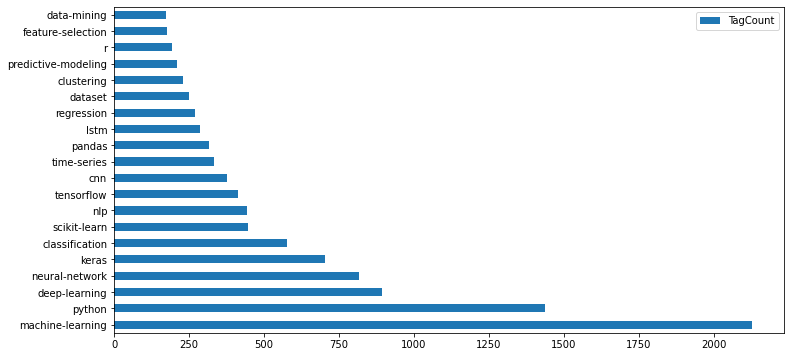

In [41]:
for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
            
tag_count = pd.DataFrame.from_dict(tag_count, orient="index")

tag_count.rename({0: "TagCount"}, axis="columns", inplace=True)
tag_count.sort_values(by="TagCount", inplace=True, ascending=False)
tag_count_top_20 = tag_count.head(20)
tag_count_top_20.plot(kind="barh", figsize=(12, 6))

<AxesSubplot:>

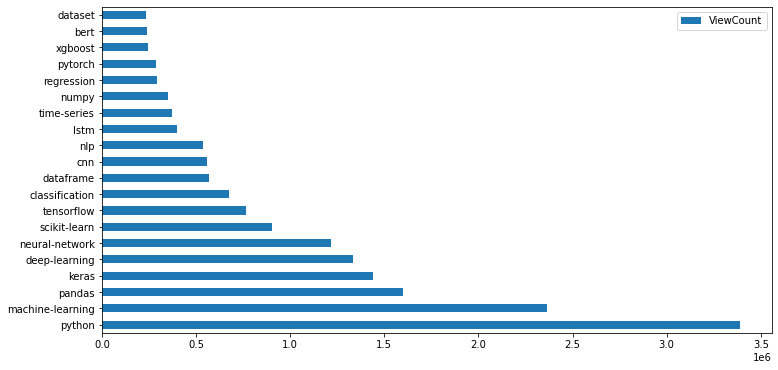

In [42]:
view_count = dict()

for index, row in questions.iterrows():
    for tag in row["Tags"]:
        if tag in view_count:
            view_count[tag] += row["ViewCount"]
        else:
            view_count[tag] = row["ViewCount"]

view_count = pd.DataFrame.from_dict(view_count, orient="index")
view_count.rename({0: "ViewCount"}, axis="columns", inplace=True)
view_count.sort_values(by="ViewCount", inplace=True, ascending=False)
view_count_top_20 = view_count.head(20)
view_count_top_20.plot(kind="barh", figsize=(12, 6))

We'd also like to gauge how pairs of tags are related to each other. The method that comes to mind is simply to create a grid of how they're associated with each other:

In [43]:
all_tags = list(tag_count.index)

In [44]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)

In [45]:
questions["Tags"]

0               [machine-learning, discriminant-analysis]
1                                              [lightgbm]
2       [machine-learning, scikit-learn, clustering, f...
3       [neural-network, keras, batch-normalization, k...
4       [machine-learning, deep-learning, image-recogn...
                              ...                        
6751                 [python, data-mining, visualization]
6752                                [feature-engineering]
6753    [classification, random-forest, accuracy, clas...
6754                                   [machine-learning]
6755                                 [deep-learning, nlp]
Name: Tags, Length: 6756, dtype: object

In [46]:
associations.fillna(0, inplace=True)

for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1

In [47]:
relations_most_used = associations.loc[tag_count_top_20.index, tag_count_top_20.index]

<AxesSubplot:>

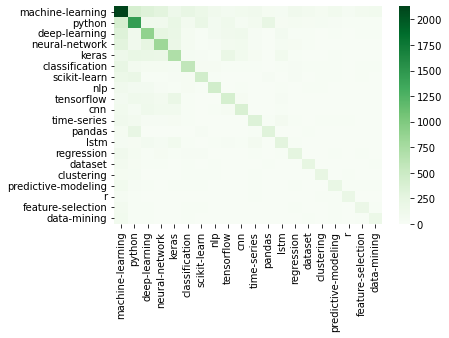

In [48]:
sns.heatmap(relations_most_used, cmap="Greens")

It's clear that the values along the diagonal are skewing the data too much. Let's remove them.

In [49]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = np.NaN

<AxesSubplot:>

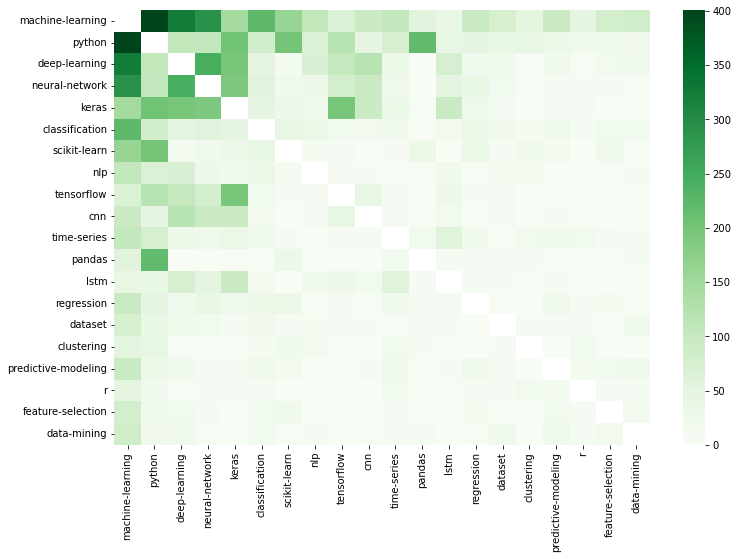

In [50]:
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens")

Finally, is deep learning a fad? Let's do the following:
- Count how many deep learning questions are asked per time period
- The total amount of questions per time period
- How many deep learning questions there are relative to the total amount of questions per time period

In [51]:
all_q = pd.read_csv("all_questions.csv")

In [52]:
all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")
all_q["CreationDate"] = pd.to_datetime(all_q["CreationDate"])

/tmp/ipykernel_12749/2237001868.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")


In [53]:
all_q.head()

,Id,CreationDate,Tags
0,28636,2018-03-05 11:05:12,"[machine-learning, python, neural-network, cla..."
1,28637,2018-03-05 11:12:06,"[neural-network, deep-learning, dropout]"
2,28639,2018-03-05 11:59:59,"[machine-learning, clustering, dataset, k-means]"
3,28650,2018-03-05 16:05:31,"[scikit-learn, linear-regression, feature-engi..."
4,28656,2018-03-05 17:48:23,[plotting]


We'll investigate the popularity of the following tags: `deep-learning, neural-network, keras, tensorflow, lstm, cnn`.

In [54]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["deep-learning", "neural-network", "keras", "tensorflow", "lstm", "cnn"]:
            return 1
    return 0

all_q["is_deep_learning"] = all_q["Tags"].apply(class_deep_learning)
all_q = all_q[all_q["CreationDate"].dt.year < 2020]
    

We'll work with a quarter-by-quarter analysis of the data. Anything less will be too granular.

In [55]:
def get_quarter(date):
    year = str(date.year)[-2:]
    quarter = str((date.month-1) // 3 + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

In [56]:
all_q["Quarter"] = all_q["CreationDate"].apply(get_quarter)

In [57]:
all_q["Quarter"].value_counts()

19Q2    1785
19Q3    1742
19Q1    1732
19Q4    1497
18Q3    1446
18Q2    1416
18Q4    1265
18Q1    1199
17Q4     887
17Q3     707
17Q1     690
17Q2     633
16Q3     575
16Q4     518
16Q1     510
16Q2     510
15Q4     379
15Q3     310
15Q2     284
14Q4     214
15Q1     188
14Q3     188
14Q2     157
Name: Quarter, dtype: int64

In [58]:
all_q.groupby(by="Quarter")["is_deep_learning"].sum()

Quarter
14Q2      7
14Q3      8
14Q4     15
15Q1     13
15Q2     20
15Q3     28
15Q4     52
16Q1     79
16Q2     78
16Q3    119
16Q4    139
17Q1    208
17Q2    186
17Q3    206
17Q4    290
18Q1    454
18Q2    489
18Q3    594
18Q4    441
19Q1    597
19Q2    577
19Q3    548
19Q4    505
Name: is_deep_learning, dtype: int64

Finally, we'll group by quarter and:
- Count the number of deep learning questions
- Count the total number of questions
- Compute the ratio of the two numbers above.

In [60]:
quarterly = all_q.groupby('Quarter').agg({"is_deep_learning": ['sum', 'size']})
quarterly.columns = ["DeepLearningQuestions", "TotalQuestions"]
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"] / quarterly["TotalQuestions"]

quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
14,17Q4,290,887,0.326945
3,15Q1,13,188,0.069149
17,18Q3,594,1446,0.410788
15,18Q1,454,1199,0.378649
18,18Q4,441,1265,0.348617


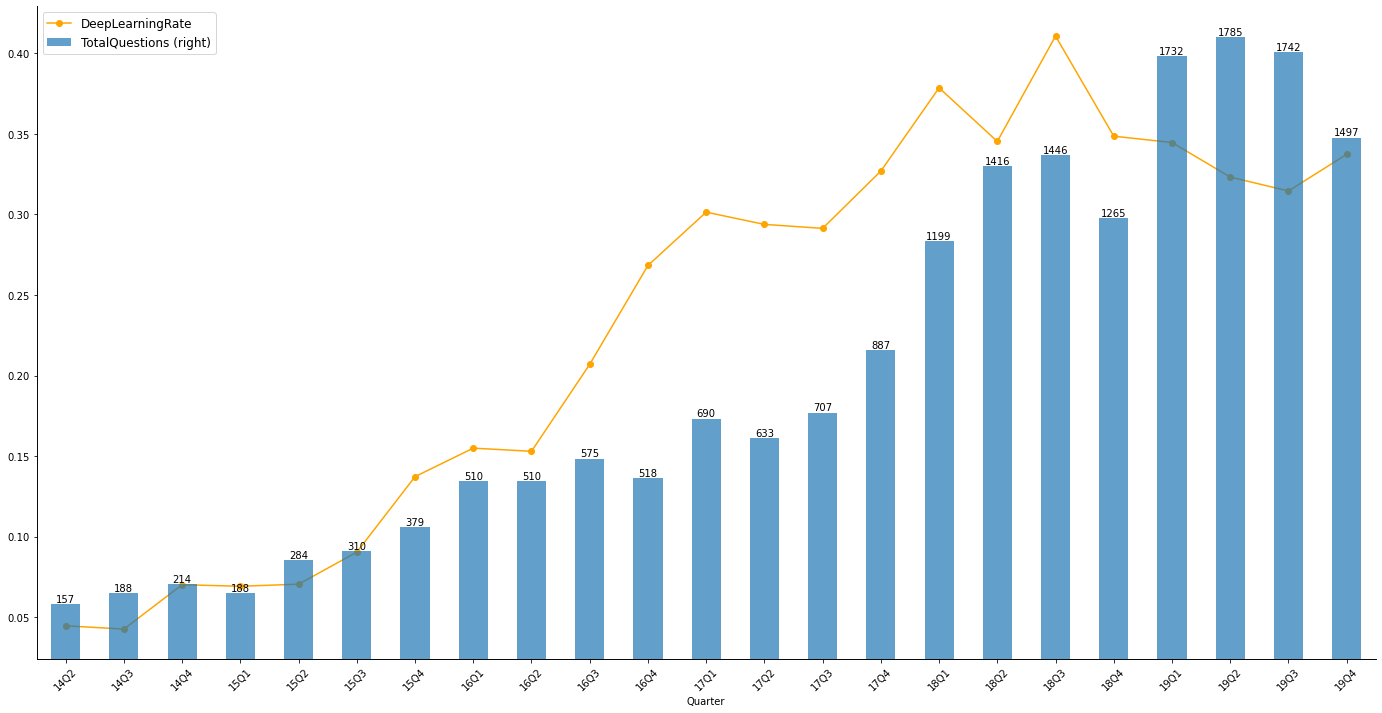

In [61]:
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

Deep learning is not just a fad! There's a trend of high growth from the inception of Data Science Stack Exchange. It looks like it is plateauing, but no evidence suggests that interest is decreasing and the proposal to continue making data science content should be accepted.